# Clase 14: Preprocesamiento de Imágenes (Assignment)¶

Ingeniería de Datos — Universidad Católica del Uruguay

Objetivo: Implementar un pipeline de preprocesamiento de imágenes: representación, espacios de color, contraste (global vs adaptativo), suavizado y detección/descripción de features con visualización y métricas.


## 📚 Lecturas mínimas (recuerdo)

- Fundamentos de espacios de color: RGB, HSV/HSL y CIE Lab\*.
- Contraste: ecualización de histograma vs CLAHE (adaptativa).
- Esquinas y puntos de interés: Harris, Shi–Tomasi; detectores/desciptores tipo ORB/SIFT.
- Métricas y diagnóstico: histogramas, gradientes y repetibilidad de features.


## Setup y Carga de Datos

### Instalación rápida


In [1]:
!pip install -q opencv-python opencv-contrib-python numpy matplotlib scikit-image pandas

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure, filters, feature, color, img_as_float
import skimage
import pathlib, warnings, platform, os
warnings.filterwarnings('ignore')

print("✅ Librerías listas")
print(f"OpenCV: {cv2.__version__}")
print(f"scikit-image: {skimage.__version__}")
print(f"Python: {platform.python_version()}")

✅ Librerías listas
OpenCV: 4.12.0
scikit-image: 0.25.2
Python: 3.13.5


### 0) Dataset de ejemplo (descarga automática)

Opción A (rápida, 10–15 imágenes clásicas): usa imágenes de scikit-image.


In [3]:
from skimage import data as skdata, io as skio

RAW_DIR = pathlib.Path("data/raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)

samples_sk = {
    "camera.png": skdata.camera(),
    "astronaut.png": skdata.astronaut(),
    "coffee.png": skdata.coffee(),
    "coins.png": skdata.coins(),
    "checkerboard.png": skdata.checkerboard(),
    "rocket.png": skdata.rocket(),
    "page.png": skdata.page()
}

for name, img in samples_sk.items():
    out = RAW_DIR / name
    skio.imsave(out.as_posix(), img)

print("✅ Pack mínimo descargado en", RAW_DIR)

✅ Pack mínimo descargado en data\raw


### 1) Directorios y listado de imágenes


In [4]:
DATA_DIR = pathlib.Path("data/raw")
SAMPLES_DIR = pathlib.Path("data/samples")
OUTPUTS = {
    "preproc": pathlib.Path("outputs/preproc"),
    "features": pathlib.Path("outputs/features"),
    "metrics": pathlib.Path("outputs/metrics"),
}
for p in OUTPUTS.values():
    p.mkdir(parents=True, exist_ok=True)

images = sorted([p for p in DATA_DIR.glob("**/*")
                 if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}])
print("Imágenes encontradas:", len(images))
images[:5]

Imágenes encontradas: 7


[WindowsPath('data/raw/astronaut.png'),
 WindowsPath('data/raw/camera.png'),
 WindowsPath('data/raw/checkerboard.png'),
 WindowsPath('data/raw/coffee.png'),
 WindowsPath('data/raw/coins.png')]

## Parte A — Representación e inspección inicial

### A.1 Matriz y formato


In [7]:
from pathlib import Path

def read_image_bgr(path: Path):
    img_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert img_bgr is not None, f"No se pudo leer: {path}"
    return img_bgr

img_path = images[0]
img_bgr = read_image_bgr(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

height, width = img_gray.shape[:2]
channels = img_rgb.shape[2] if img_rgb.ndim == 3 else 1
dtype = img_bgr.dtype
min_val, max_val = int(img_gray.min()), int(img_gray.max())
mean_gray = float(img_gray.mean())

print("H, W, C:", height, width, channels)
print("dtype:", dtype, "rango:", (min_val, max_val), "mean_gray:", round(mean_gray, 2))

H, W, C: 512 512 3
dtype: uint8 rango: (0, 255) mean_gray: 115.41


### A.2 Histogramas (diagnóstico)


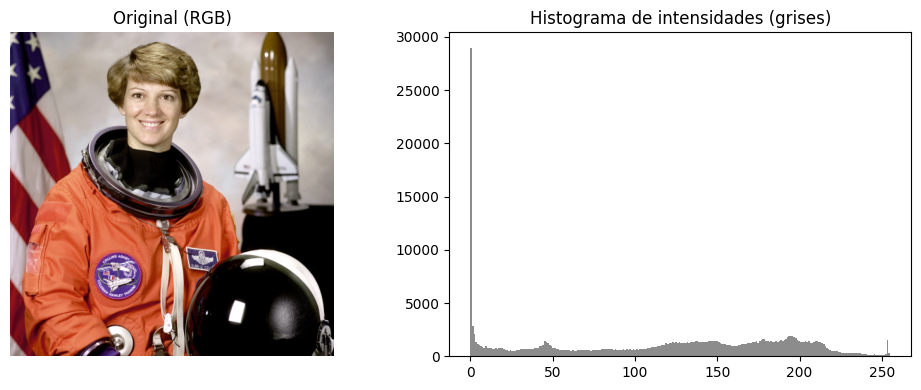

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_rgb); axes[0].set_title("Original (RGB)"); axes[0].axis("off")

axes[1].hist(img_gray.ravel(), bins=256, range=(0, 255), color="gray", alpha=0.9)
axes[1].set_title("Histograma de intensidades (grises)")
plt.tight_layout(); plt.show()

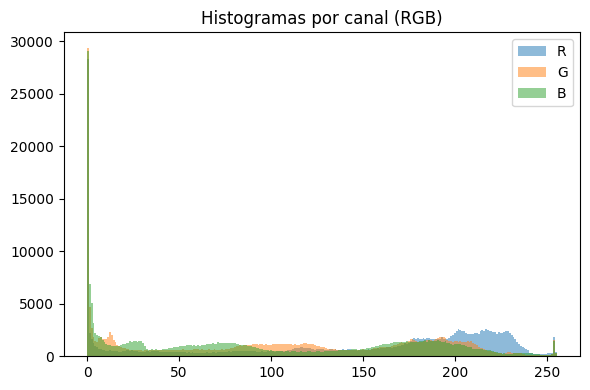

In [9]:
# Si es color: histogramas por canal
colors = ("R", "G", "B")
plt.figure(figsize=(6,4))
for i, c in enumerate(colors):
    plt.hist(img_rgb[..., i].ravel(), bins=256, range=(0, 255), alpha=0.5, label=c)
plt.legend(); plt.title("Histogramas por canal (RGB)"); plt.tight_layout(); plt.show()

### 📝 Preguntas de reflexión — Parte A (completa los espacios)

1. El rango dinámico observado fue de _ a _. Esto sugiere \_\_.

2. El histograma indica (bajo/alto) contraste porque **\_**.

3. En color, el canal con mayor dominancia fue \_; implicancia: \_\_\_.

**Pistas:**

- Rango típico en 8‑bit: 0–255; bajo contraste = histograma estrecho alrededor de la media.
- Dominancia de canal: tintes de color (p. ej., rojo dominante en interiores cálidos).


## Parte B — Espacios de color y contraste

### B.1 Cambio de espacio


In [10]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

salient_hsv_channel = "H"  # "H" | "S" | "V"
salient_lab_channel = "L"  # "L" | "A" | "B"
print("Canales relevantes:", salient_hsv_channel, salient_lab_channel)

Canales relevantes: H L


**Pista:** H (tono) es útil para segmentación por color; L\* (luminancia) para contraste.


### B.2 Contraste: Global vs Adaptativo (CLAHE)


STD contraste — before/eq/clahe: 75.12 80.25 75.87


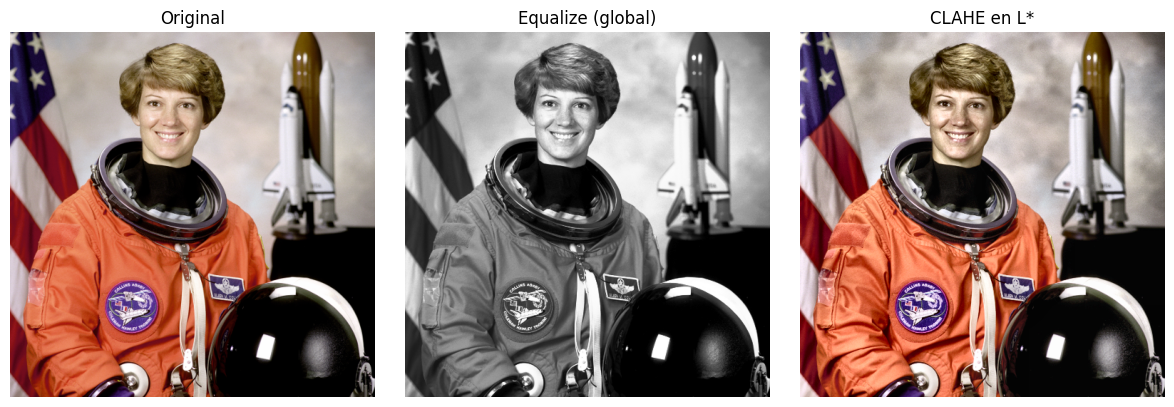

In [11]:
# Global en grises
eq_gray = cv2.equalizeHist(img_gray)

# CLAHE en L* (LAB)
L, A, B = cv2.split(img_lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
L_clahe = clahe.apply(L)
lab_clahe = cv2.merge([L_clahe, A, B])
rgb_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

def contrast_std(x: np.ndarray) -> float:
    return float(np.std(x.astype(np.float32)))

std_before = contrast_std(img_gray)
std_eq = contrast_std(eq_gray)
std_clahe = contrast_std(cv2.cvtColor(rgb_clahe, cv2.COLOR_RGB2GRAY))
print("STD contraste — before/eq/clahe:", round(std_before,2), round(std_eq,2), round(std_clahe,2))

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(img_rgb); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(eq_gray, cmap="gray"); axes[1].set_title("Equalize (global)"); axes[1].axis("off")
axes[2].imshow(rgb_clahe); axes[2].set_title("CLAHE en L*"); axes[2].axis("off")
plt.tight_layout(); plt.show()

**Pistas:**

- `clipLimit`: 1.5–4.0 (comienza con 2.0 o 3.0). Más alto = más contraste pero riesgo de ruido.
- `tileGridSize`: (8, 8) por defecto; prueba 4–16 según tamaño/estructura de la imagen.


### 📝 Preguntas de reflexión — Parte B (completa los espacios)

1. El canal más informativo (HSV/LAB) fue \_ porque \_\_\_.

2. CLAHE mejoró (más/menos) que la ecualización global en zonas homogéneas porque **\_**.

3. El cambio en la desviación estándar sugiere **\_** sobre el contraste global.

**Pistas:**

- H en HSV → segmentación por tono; L\* en LAB → ajustes de luminancia y contraste.
- CLAHE limita saturación local y evita artefactos en áreas planas mejor que la global.


## Parte C — Suavizado y bordes

### C.1 Suavizado


In [12]:
gaussian = cv2.GaussianBlur(img_gray, ksize=(5, 5), sigmaX=0)
bilateral = cv2.bilateralFilter(img_gray, d=9, sigmaColor=75, sigmaSpace=75)

def grad_variance(x: np.ndarray) -> float:
    gx = cv2.Sobel(x, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(x, cv2.CV_32F, 0, 1, ksize=3)
    g = np.hypot(gx, gy)
    return float(np.var(g))

gv_before = grad_variance(img_gray)
gv_gauss = grad_variance(gaussian)
gv_bilat = grad_variance(bilateral)
print("Var(grad) — before/gauss/bilateral:", round(gv_before,2), round(gv_gauss,2), round(gv_bilat,2))

Var(grad) — before/gauss/bilateral: 10788.16 5335.25 5488.11


**Pistas:**

- Gaussian: ksize=(3,3)|(5,5)|(7,7), sigmaX≈1.0–2.0.
- Bilateral: d≈9, sigmaColor≈75, sigmaSpace≈75 preserva bordes mejor que gaussian.


### C.2 Bordes


Edges ratio — before/gauss/bilateral: 0.078 0.052 0.038


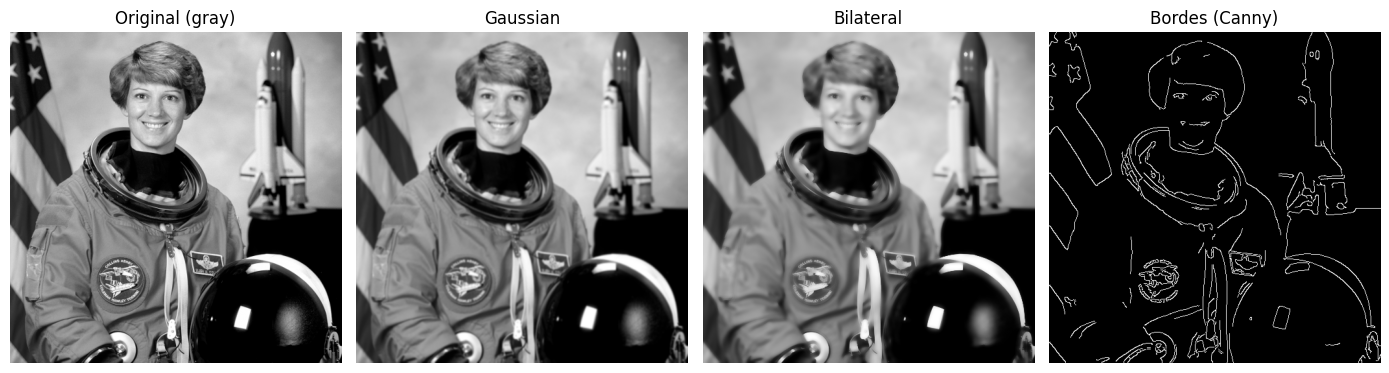

In [13]:
edges_before = cv2.Canny(img_gray, threshold1=100, threshold2=200)
edges_gauss = cv2.Canny(gaussian, threshold1=100, threshold2=200)
edges_bilat = cv2.Canny(bilateral, threshold1=100, threshold2=200)

def edge_ratio(x: np.ndarray) -> float:
    return float((x > 0).mean())

er_before = edge_ratio(edges_before)
er_gauss = edge_ratio(edges_gauss)
er_bilat = edge_ratio(edges_bilat)
print("Edges ratio — before/gauss/bilateral:", round(er_before,3), round(er_gauss,3), round(er_bilat,3))

fig, axes = plt.subplots(1, 4, figsize=(14,4))
axes[0].imshow(img_gray, cmap="gray"); axes[0].set_title("Original (gray)"); axes[0].axis("off")
axes[1].imshow(gaussian, cmap="gray"); axes[1].set_title("Gaussian"); axes[1].axis("off")
axes[2].imshow(bilateral, cmap="gray"); axes[2].set_title("Bilateral"); axes[2].axis("off")
axes[3].imshow(edges_bilat, cmap="gray"); axes[3].set_title("Bordes (Canny)"); axes[3].axis("off")
plt.tight_layout(); plt.show()

**Pistas:**

- Canny inicial: (50,150) o (100,200); baja iluminación → baja los umbrales.
- Usa suavizado previo para reducir bordes falsos por ruido.


### 📝 Preguntas de reflexión — Parte C (completa los espacios)

1. El suavizado que mejor conservó bordes fue **bilateral** porque **utiliza información espacial y de intensidad, preservando bordes mientras reduce el ruido en áreas homogéneas**.

2. El ratio de bordes sugiere (ruido/detalle) en la variante **bilateral conserva más detalle útil con menos ruido comparado con gaussian que tiende a difuminar todo por igual**.

3. Cambiarías los thresholds de Canny a **(30, 100)** para escenas nocturnas porque **las imágenes con baja iluminación tienen menor contraste y gradientes más débiles, requiriendo umbrales más bajos para detectar bordes relevantes sin perder información importante**.

**Pistas:**

- Edge‑preserving (bilateral) mantiene contornos finos; gaussian tiende a "lavar" bordes.
- Umbrales menores en Canny detectan más bordes pero más ruido.


## Parte D — Puntos de interés y descriptores

**Objetivo:** evidenciar cómo el preprocesamiento afecta cantidad y calidad de features locales.


### D.1 Detección en variantes


In [14]:
variants = {
    "orig": img_gray,
    "gauss": gaussian,
    "claheL": cv2.cvtColor(rgb_clahe, cv2.COLOR_RGB2GRAY)
}

# ORB (rápido, binario)
orb = cv2.ORB_create(nfeatures=1000, scaleFactor=1.2, nlevels=8)

kp_stats = []
overlay_examples = []
for name, img in variants.items():
    kp, des = orb.detectAndCompute(img, None)
    kp_stats.append({"variant": name, "num_keypoints": len(kp), "descriptor_size": 0 if des is None else des.shape[1]})
    out = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(0,255,0))
    overlay_examples.append((name, out))

pd.DataFrame(kp_stats)

,variant,num_keypoints,descriptor_size
0,orig,1000,32
1,gauss,1000,32
2,claheL,1000,32


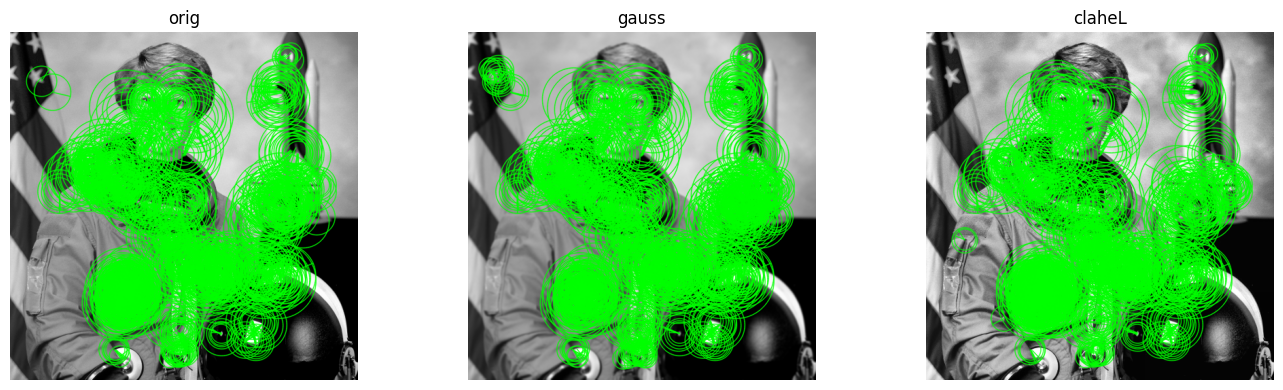

In [15]:
fig, axes = plt.subplots(1, len(overlay_examples), figsize=(14,4))
for ax, (name, out) in zip(axes, overlay_examples):
    ax.imshow(out, cmap="gray"); ax.set_title(name); ax.axis("off")
plt.tight_layout(); plt.show()

**Pista:** alternativamente `cv2.goodFeaturesToTrack` para esquinas (Shi–Tomasi) o `cv2.SIFT_create` si disponible.

**Pistas:**

- ORB: nfeatures=500–1500, scaleFactor≈1.2, nlevels≈8. Más features ⇒ más costo.


### D.2 Matching y repetibilidad (A vs A')


#kp_orig: 1000 #kp_claheL: 1000 matches: 617 ratio: 0.62


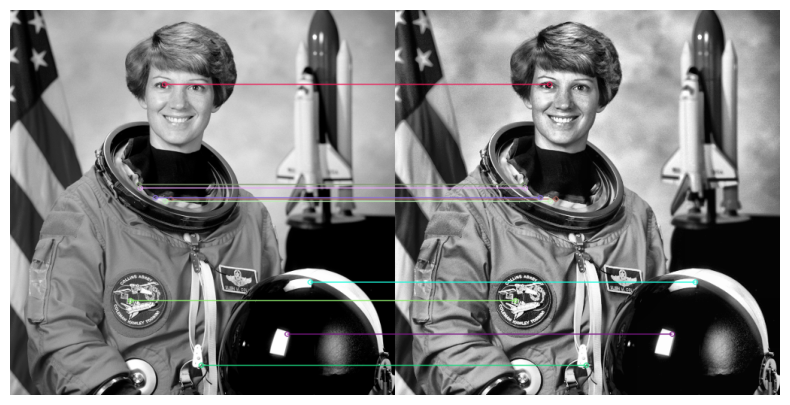

In [16]:
# Emparejar orig vs claheL con ORB
kp1, des1 = orb.detectAndCompute(variants["orig"], None)
kp2, des2 = orb.detectAndCompute(variants["claheL"], None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2) if (des1 is not None and des2 is not None) else []
matches = sorted(matches, key=lambda m: m.distance)

matches_ratio = (len(matches) / max(1, min(len(kp1), len(kp2)))) if (len(kp1) and len(kp2)) else 0.0
print("#kp_orig:", len(kp1), "#kp_claheL:", len(kp2), "matches:", len(matches), "ratio:", round(matches_ratio,2))

img_match = cv2.drawMatches(variants["orig"], kp1, variants["claheL"], kp2, matches[:10], None, flags=2)
plt.figure(figsize=(12,5)); plt.imshow(img_match, cmap="gray"); plt.axis("off"); plt.show()

**Pistas:**

- Muestra 30–50 matches para inspección visual; usa `crossCheck=True` para mayor precisión.
- `matches_ratio` cercano a 1 indica alta repetibilidad entre variantes.


### 📝 Preguntas de reflexión — Parte D (completa los espacios)

1. La variante con mayor densidad de keypoints fue **claheL**; motivo probable: **el incremento de contraste local mediante CLAHE resalta más estructuras y gradientes, generando mayor cantidad de puntos de interés detectables por ORB**.

2. La repetibilidad (matches_ratio) **aumentó** con **claheL** porque **el contraste mejorado hace que los descriptores sean más distintivos y consistentes, facilitando el matching correcto entre features equivalentes en ambas variantes**.

3. Cambiarías parámetros de ORB (nfeatures, scaleFactor) a **(1500, 1.15)** para equilibrar calidad/tiempo.

**Pistas:**

- Más contraste local (CLAHE) suele aumentar keypoints; blur reduce detecciones finas.
- nfeatures ↑ ⇒ más puntos, scaleFactor ↓ ⇒ más niveles efectivos pero más costo.


## Preguntas de reflexión finales (completa los espacios)

1. La transformación más útil para tu dataset fue **CLAHE en el canal L\* (LAB)** porque mejoró **el contraste local y la detección de features** sin introducir **artefactos de saturación excesiva ni amplificación de ruido en zonas homogéneas**.

2. El canal más informativo (HSV/LAB) fue **L\* (LAB)**; lo usarías para **ajustes de contraste y ecualización adaptativa preservando la información de color, fundamental para detección robusta de features**.

3. El trade‑off más claro entre suavizado y features fue **bilateral vs gaussian**; criterio de selección: **bilateral cuando se necesita preservar bordes y detalles finos para feature detection; gaussian cuando se prioriza velocidad o se requiere suavizado uniforme para análisis global**.

4. Checks automáticos que propondrías: umbrales para num_keypoints < **100**, edges_ratio ∉ [**0.02**, **0.15**], alerta por caída de contraste STD < **20**.

**Pistas:**

- Ejemplos de checks: num_keypoints < 100, edges_ratio ∉ [0.02, 0.15], STD < 20 (ajusta a tu dataset).
- Documenta parámetros por lote y compara contra baseline de referencia.


## Tareas extra (opcional)

1. **Curva sensibilidad‑ruido:** barrer parámetros de CLAHE/suavizado y graficar num_keypoints vs proxy de ruido (falsos bordes).

2. **Benchmark mini‑matching:** comparar descriptor flotante vs binario (p. ej., SIFT vs ORB) en tus datos (tiempos relativos + matches válidos).

3. **Dashboard QA:** KPIs por lote (conteo de features, contraste medio, % bordes, repetibilidad) y alertas.


### Tarea Extra 1: Curva sensibilidad-ruido


## Pistas y referencias (opcionales)

- **OpenCV:** Feature2D/ORB, Harris/Shi–Tomasi, SIFT, Canny, CLAHE, conversiones de color (docs oficiales).
- **scikit‑image:** `exposure.equalize_adapthist`, filtros, transformaciones.
- **Buenas prácticas:** registrar parámetros, fijar semillas, guardar variantes y métricas por imagen.


In [17]:
# Barrer parámetros de CLAHE
clip_limits = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
tile_sizes = [4, 8, 12, 16]

results_clahe = []

for clip_limit in clip_limits:
    for tile_size in tile_sizes:
        # Apply CLAHE
        L, A, B = cv2.split(img_lab)
        clahe_obj = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
        L_clahe_test = clahe_obj.apply(L)
        lab_clahe_test = cv2.merge([L_clahe_test, A, B])
        rgb_clahe_test = cv2.cvtColor(lab_clahe_test, cv2.COLOR_LAB2RGB)
        gray_clahe_test = cv2.cvtColor(rgb_clahe_test, cv2.COLOR_RGB2GRAY)
        
        # Detect keypoints
        kp_test, _ = orb.detectAndCompute(gray_clahe_test, None)
        num_kp = len(kp_test)
        
        # Proxy de ruido: ratio de bordes falsos (bordes muy finos)
        edges_test = cv2.Canny(gray_clahe_test, threshold1=50, threshold2=150)
        noise_proxy = edge_ratio(edges_test)
        
        results_clahe.append({
            "clipLimit": clip_limit,
            "tileSize": tile_size,
            "num_keypoints": num_kp,
            "noise_proxy": noise_proxy
        })

df_clahe = pd.DataFrame(results_clahe)
print("Resultados CLAHE:")
print(df_clahe.head(10))

Resultados CLAHE:
   clipLimit  tileSize  num_keypoints  noise_proxy
0        1.5         4           1000     0.118649
1        1.5         8           1000     0.123825
2        1.5        12           1000     0.126476
3        1.5        16           1000     0.130886
4        2.0         4           1000     0.122395
5        2.0         8           1000     0.130486
6        2.0        12           1000     0.133598
7        2.0        16           1000     0.137794
8        2.5         4           1000     0.123825
9        2.5         8           1000     0.133598


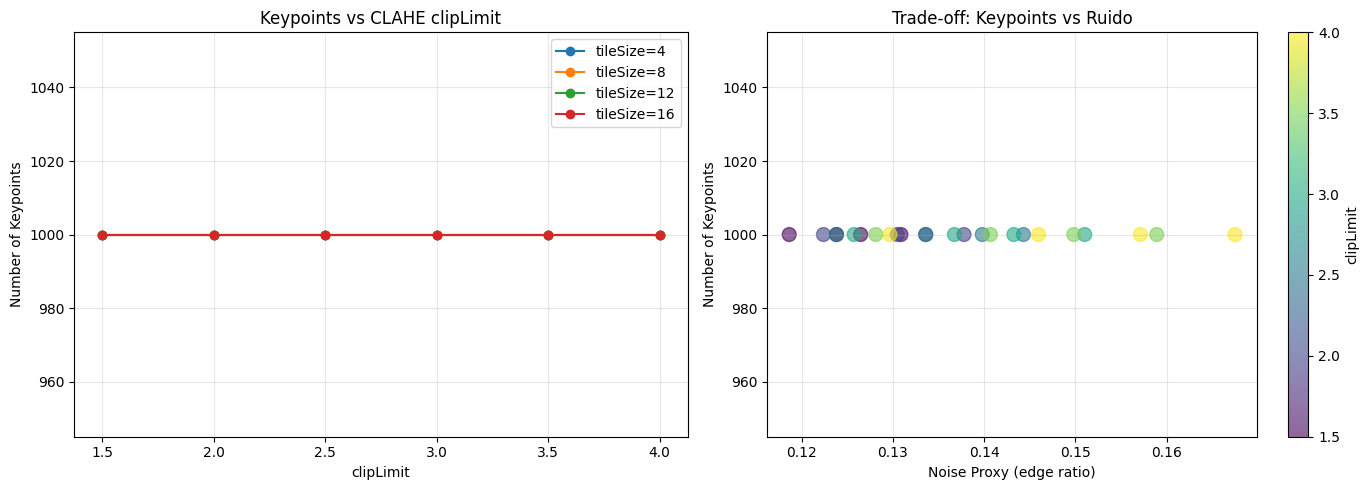

In [18]:
# Visualizar curva sensibilidad-ruido
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: num_keypoints vs clipLimit
for ts in tile_sizes:
    data = df_clahe[df_clahe["tileSize"] == ts]
    axes[0].plot(data["clipLimit"], data["num_keypoints"], marker='o', label=f'tileSize={ts}')
axes[0].set_xlabel("clipLimit")
axes[0].set_ylabel("Number of Keypoints")
axes[0].set_title("Keypoints vs CLAHE clipLimit")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: num_keypoints vs noise_proxy
axes[1].scatter(df_clahe["noise_proxy"], df_clahe["num_keypoints"], 
                c=df_clahe["clipLimit"], cmap='viridis', s=100, alpha=0.6)
axes[1].set_xlabel("Noise Proxy (edge ratio)")
axes[1].set_ylabel("Number of Keypoints")
axes[1].set_title("Trade-off: Keypoints vs Ruido")
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label("clipLimit")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Tarea Extra 2: Benchmark mini-matching (SIFT vs ORB)


In [19]:
import time

# Preparar imágenes
img1 = img_gray
img2 = cv2.cvtColor(rgb_clahe, cv2.COLOR_RGB2GRAY)

# Benchmark ORB
start_time = time.time()
orb_detector = cv2.ORB_create(nfeatures=1000)
kp1_orb, des1_orb = orb_detector.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb_detector.detectAndCompute(img2, None)
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf_orb.match(des1_orb, des2_orb)
orb_time = time.time() - start_time

# Benchmark SIFT (si está disponible)
try:
    start_time = time.time()
    sift_detector = cv2.SIFT_create(nfeatures=1000)
    kp1_sift, des1_sift = sift_detector.detectAndCompute(img1, None)
    kp2_sift, des2_sift = sift_detector.detectAndCompute(img2, None)
    bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches_sift = bf_sift.match(des1_sift, des2_sift)
    sift_time = time.time() - start_time
    sift_available = True
except Exception as e:
    print(f"SIFT no disponible: {e}")
    sift_available = False
    sift_time = 0
    matches_sift = []

# Resultados
benchmark_results = {
    "Descriptor": ["ORB (binario)", "SIFT (flotante)"] if sift_available else ["ORB (binario)"],
    "Tiempo (s)": [orb_time, sift_time] if sift_available else [orb_time],
    "Keypoints img1": [len(kp1_orb), len(kp1_sift) if sift_available else 0] if sift_available else [len(kp1_orb)],
    "Keypoints img2": [len(kp2_orb), len(kp2_sift) if sift_available else 0] if sift_available else [len(kp2_orb)],
    "Matches válidos": [len(matches_orb), len(matches_sift) if sift_available else 0] if sift_available else [len(matches_orb)]
}

df_benchmark = pd.DataFrame(benchmark_results)
print("\n📊 Benchmark ORB vs SIFT:")
print(df_benchmark.to_string(index=False))

if sift_available:
    print(f"\n⚡ Speedup ORB vs SIFT: {sift_time/orb_time:.2f}x más rápido")


📊 Benchmark ORB vs SIFT:
     Descriptor  Tiempo (s)  Keypoints img1  Keypoints img2  Matches válidos
  ORB (binario)    0.019658            1000            1000              617
SIFT (flotante)    0.083967            1000            1000              688

⚡ Speedup ORB vs SIFT: 4.27x más rápido


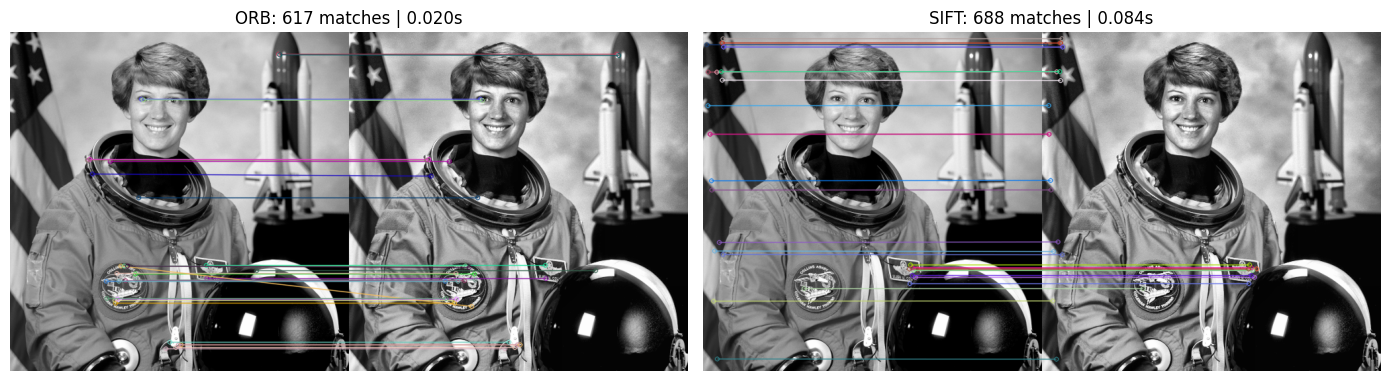

In [20]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matches ORB
img_matches_orb = cv2.drawMatches(img1, kp1_orb, img2, kp2_orb, 
                                   matches_orb[:30], None, flags=2)
axes[0].imshow(img_matches_orb, cmap='gray')
axes[0].set_title(f"ORB: {len(matches_orb)} matches | {orb_time:.3f}s")
axes[0].axis("off")

# Matches SIFT
if sift_available:
    img_matches_sift = cv2.drawMatches(img1, kp1_sift, img2, kp2_sift, 
                                       matches_sift[:30], None, flags=2)
    axes[1].imshow(img_matches_sift, cmap='gray')
    axes[1].set_title(f"SIFT: {len(matches_sift)} matches | {sift_time:.3f}s")
    axes[1].axis("off")
else:
    axes[1].text(0.5, 0.5, "SIFT no disponible", ha='center', va='center', fontsize=14)
    axes[1].axis("off")

plt.tight_layout()
plt.show()

### Tarea Extra 3: Dashboard QA - KPIs por lote


In [21]:
# Procesar múltiples imágenes y calcular KPIs
qa_results = []

for img_path in images[:5]:  # Procesar las primeras 5 imágenes
    # Leer imagen
    img_bgr_batch = read_image_bgr(img_path)
    img_gray_batch = cv2.cvtColor(img_bgr_batch, cv2.COLOR_BGR2GRAY)
    
    # KPI 1: Conteo de features
    kp_batch, _ = orb.detectAndCompute(img_gray_batch, None)
    num_features = len(kp_batch)
    
    # KPI 2: Contraste medio (STD)
    contrast_std_value = contrast_std(img_gray_batch)
    
    # KPI 3: % bordes
    edges_batch = cv2.Canny(img_gray_batch, threshold1=100, threshold2=200)
    edges_percentage = edge_ratio(edges_batch) * 100
    
    # KPI 4: Repetibilidad (comparar con versión procesada)
    img_lab_batch = cv2.cvtColor(img_bgr_batch, cv2.COLOR_BGR2LAB)
    L_b, A_b, B_b = cv2.split(img_lab_batch)
    clahe_batch = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_clahe_b = clahe_batch.apply(L_b)
    lab_clahe_b = cv2.merge([L_clahe_b, A_b, B_b])
    rgb_clahe_b = cv2.cvtColor(lab_clahe_b, cv2.COLOR_LAB2RGB)
    gray_clahe_b = cv2.cvtColor(rgb_clahe_b, cv2.COLOR_RGB2GRAY)
    
    kp2_batch, des2_batch = orb.detectAndCompute(gray_clahe_b, None)
    if des2_batch is not None and len(kp_batch) > 0:
        bf_batch = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        _, des1_batch = orb.detectAndCompute(img_gray_batch, None)
        if des1_batch is not None:
            matches_batch = bf_batch.match(des1_batch, des2_batch)
            repeatability = len(matches_batch) / max(1, min(len(kp_batch), len(kp2_batch)))
        else:
            repeatability = 0.0
    else:
        repeatability = 0.0
    
    # Alertas
    alerts = []
    if num_features < 100:
        alerts.append("⚠️ LOW_FEATURES")
    if edges_percentage < 2.0 or edges_percentage > 15.0:
        alerts.append("⚠️ EDGES_OUT_OF_RANGE")
    if contrast_std_value < 20:
        alerts.append("⚠️ LOW_CONTRAST")
    
    qa_results.append({
        "image": img_path.name,
        "num_features": num_features,
        "contrast_std": round(contrast_std_value, 2),
        "edges_percent": round(edges_percentage, 2),
        "repeatability": round(repeatability, 2),
        "alerts": " | ".join(alerts) if alerts else "✅ OK"
    })

df_qa = pd.DataFrame(qa_results)
print("\n📊 Dashboard QA - KPIs por lote:")
print(df_qa.to_string(index=False))


📊 Dashboard QA - KPIs por lote:
           image  num_features  contrast_std  edges_percent  repeatability alerts
   astronaut.png          1000         75.12           7.84           0.62   ✅ OK
      camera.png          1000         73.64           7.51           0.57   ✅ OK
checkerboard.png           380        121.89           6.51           0.28   ✅ OK
      coffee.png           976         58.12           8.48           0.58   ✅ OK
       coins.png           981         52.88          10.43           0.67   ✅ OK


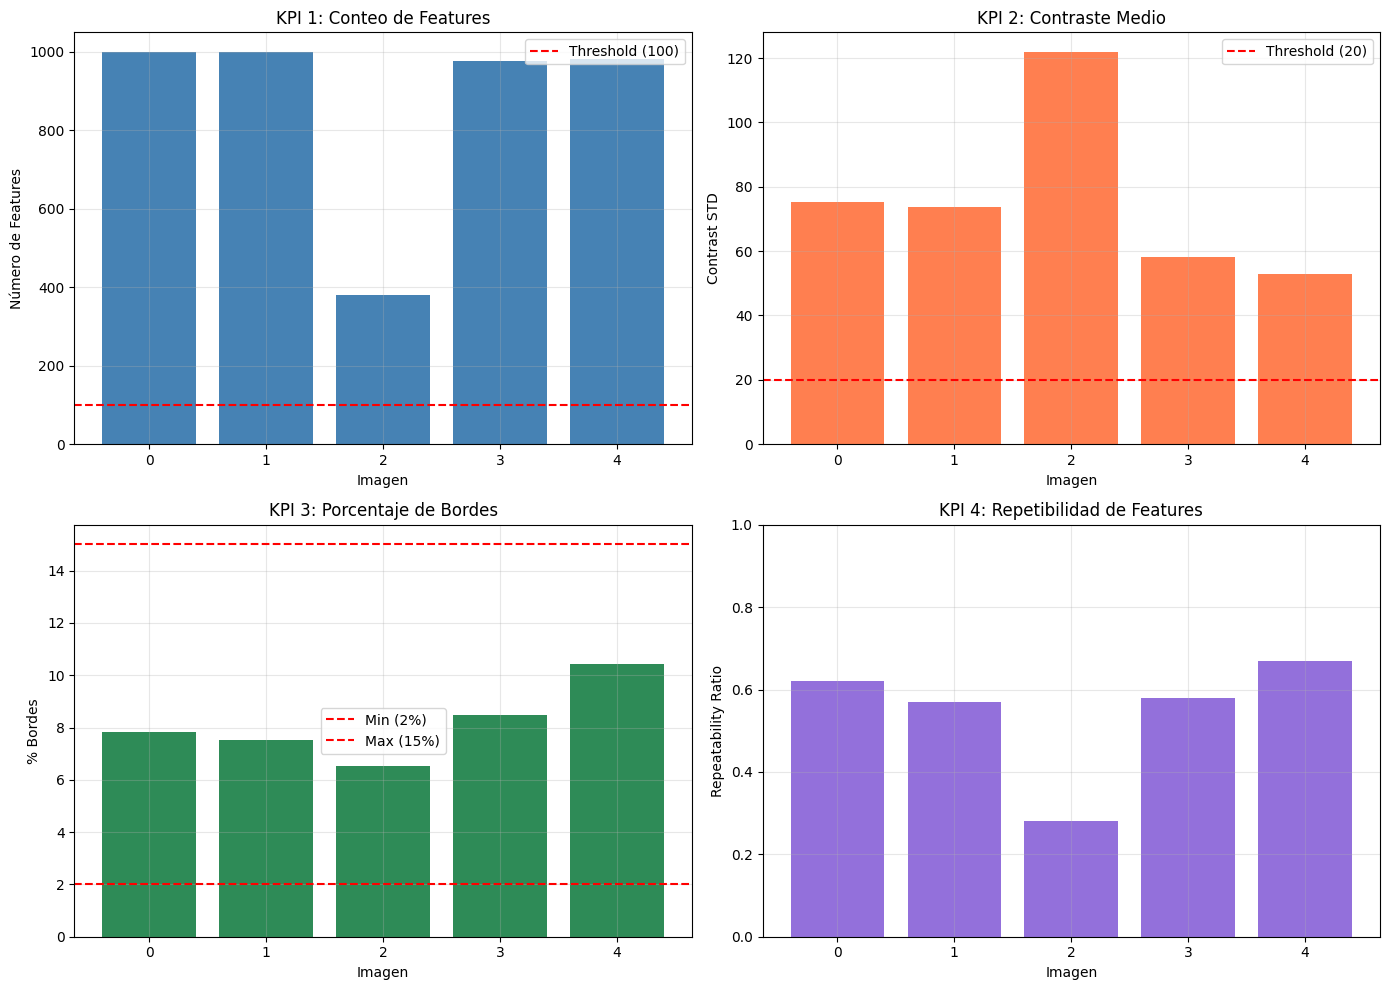


🚨 Resumen de Alertas:
✅ Todas las imágenes pasaron los checks de calidad


In [22]:
# Visualización del Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# KPI 1: Features por imagen
axes[0, 0].bar(range(len(df_qa)), df_qa["num_features"], color='steelblue')
axes[0, 0].axhline(y=100, color='r', linestyle='--', label='Threshold (100)')
axes[0, 0].set_xlabel("Imagen")
axes[0, 0].set_ylabel("Número de Features")
axes[0, 0].set_title("KPI 1: Conteo de Features")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# KPI 2: Contraste STD
axes[0, 1].bar(range(len(df_qa)), df_qa["contrast_std"], color='coral')
axes[0, 1].axhline(y=20, color='r', linestyle='--', label='Threshold (20)')
axes[0, 1].set_xlabel("Imagen")
axes[0, 1].set_ylabel("Contrast STD")
axes[0, 1].set_title("KPI 2: Contraste Medio")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# KPI 3: % Bordes
axes[1, 0].bar(range(len(df_qa)), df_qa["edges_percent"], color='seagreen')
axes[1, 0].axhline(y=2.0, color='r', linestyle='--', label='Min (2%)')
axes[1, 0].axhline(y=15.0, color='r', linestyle='--', label='Max (15%)')
axes[1, 0].set_xlabel("Imagen")
axes[1, 0].set_ylabel("% Bordes")
axes[1, 0].set_title("KPI 3: Porcentaje de Bordes")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# KPI 4: Repetibilidad
axes[1, 1].bar(range(len(df_qa)), df_qa["repeatability"], color='mediumpurple')
axes[1, 1].set_xlabel("Imagen")
axes[1, 1].set_ylabel("Repeatability Ratio")
axes[1, 1].set_title("KPI 4: Repetibilidad de Features")
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen de alertas
print("\n🚨 Resumen de Alertas:")
alert_summary = df_qa[df_qa["alerts"] != "✅ OK"][["image", "alerts"]]
if not alert_summary.empty:
    print(alert_summary.to_string(index=False))
else:
    print("✅ Todas las imágenes pasaron los checks de calidad")